## VAR model
To implement VAR after data preprocessing, causality tests, stationarity tests have been completed.

In [45]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

In [46]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

In [47]:
df.head()

,Unnamed: 0,Month_Dt,Month,Year,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),HRC - RM \nSpread ($/t),CS Production (Mnt),Exports \n(Mnt),...,Monthly Export of semis & finished steel (Mt.),YTD Iron ore Imports (Mt.),YTD Iron ore Production (Mt.),Monthly Iron ore Production (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y),Manufacturing PMI for steel
0,8,2006-09-01,9,2006,472,252,211,261,36.0,5.0,...,5.14,247.20,405.80,56.50,24.3,24.0,6.0,34.2,3.9,51.7
1,9,2006-10-01,10,2006,477,260,185,292,38.0,5.0,...,5.19,297.69,462.30,56.50,24.1,25.1,11.4,31.8,6.7,55.9
2,10,2006-11-01,11,2006,470,262,182,288,38.0,6.0,...,6.11,297.69,521.50,59.20,24.0,26.1,8.3,28.9,7.2,54.9
3,11,2006-12-01,12,2006,470,270,188,282,39.0,6.0,...,6.05,326.30,588.20,66.70,21.8,27.0,13.1,15.8,16.1,50.1
4,12,2007-01-01,1,2007,470,273,197,273,38.0,5.0,...,4.95,133.55,252.28,69.01,24.3,45.0,8.6,15.8,16.1,55.4


### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production

In [48]:
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Month_Dt,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
0,2006-09-01,472,211,261,14.0
1,2006-10-01,477,185,292,14.0
2,2006-11-01,470,182,288,16.0
3,2006-12-01,470,188,282,15.0
4,2007-01-01,470,197,273,13.0


In [49]:
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
Date,,,,
2006-09-01,472,211,261,14.0
2006-10-01,477,185,292,14.0
2006-11-01,470,182,288,16.0
2006-12-01,470,188,282,15.0
2007-01-01,470,197,273,13.0


In [50]:
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)

(204, 4)
(12, 4)


In [51]:
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.31,19.37,2.423e+08,19.33
1,13.84,14.18*,1.027e+06,13.98
2,13.58,14.19,7.882e+05,13.82*
3,13.52,14.40,7.413e+05,13.87
4,13.42*,14.57,6.719e+05*,13.88
5,13.42,14.85,6.786e+05,14.00
6,13.43,15.13,6.860e+05,14.12
7,13.48,15.45,7.241e+05,14.28
8,13.51,15.75,7.441e+05,14.41
9,13.61,16.12,8.263e+05,14.62


In [52]:
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Mar, 2025
Time:                     16:32:35
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.6074
Nobs:                     200.000    HQIC:                   13.9398
Log likelihood:          -2415.74    FPE:                    720410.
AIC:                      13.4859    Det(Omega_mle):         519830.
--------------------------------------------------------------------
Results for equation HRC 
(FOB, $/t)
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               48.409201        13.702080            3.533           0.000
L1.HRC 
(FOB, $/t)                   8.498117         4.830025            1.759       

In [53]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC 
(FOB, $/t) : 1.95
RM Cost 
($/t) : 2.04
HRC - RM 
Spread ($/t) : 2.05
Export as % of Production : 1.98


In [54]:
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input

array([[561., 399., 163.,   9.],
       [542., 411., 131.,   8.],
       [550., 412., 138.,   8.],
       [553., 430., 124.,  10.]])

In [55]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df_test.index, columns=final_df_test.columns + '_f')
df_forecast

,"HRC \n(FOB, $/t)_f",RM Cost \n($/t)_f,HRC - RM \nSpread ($/t)_f,Export as % of Production_f
Date,,,,
2023-09-01,554.441580,420.866408,133.517514,9.705764
2023-10-01,544.100800,404.260869,139.749810,9.360035
2023-11-01,534.457080,390.243986,144.273361,9.342363
2023-12-01,529.392911,380.044490,149.267655,9.093810
2024-01-01,524.099548,369.976004,154.038938,8.944269
2024-02-01,518.349690,361.615319,156.671351,8.891951
2024-03-01,514.922392,354.578694,160.270738,8.829521
2024-04-01,512.872563,348.904212,163.897509,8.781519
2024-05-01,511.890166,345.023536,166.802653,8.749414


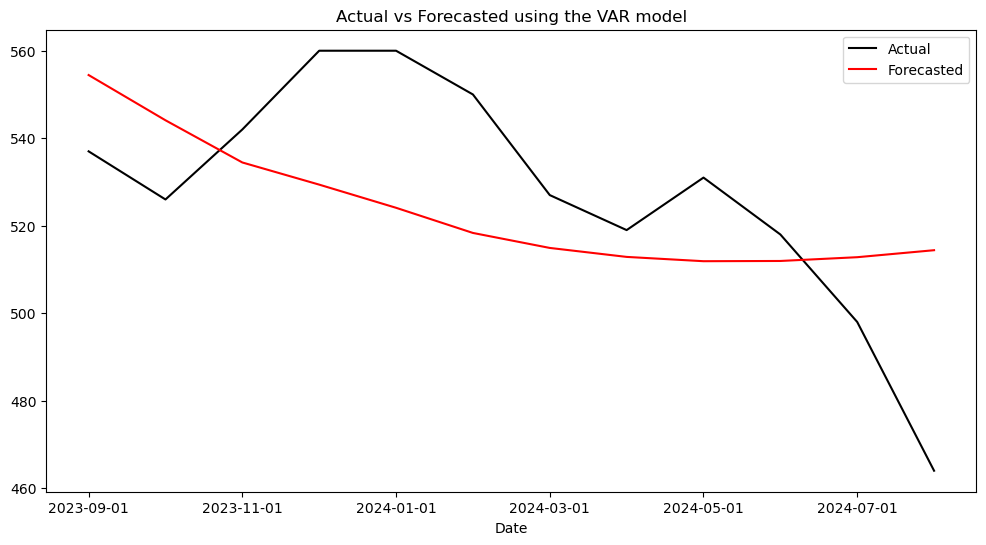

In [56]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()

In [57]:
# Error metrics

forecast = df_forecast['HRC \n(FOB, $/t)_f'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  20.81854274214851
Root Mean Squared Error:  24.59861818786813
Mean Absolute Percentage Error:  0.039823221204116244


### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.